In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [3]:
path = 'FishDiseaseZHAW/OverUnderWeight'
ids = []
for img in os.listdir(path):
    ids.append(path + '/' + img)
df = pd.DataFrame(ids, columns=['id'])

In [4]:
import cv2
import re
import easyocr

def get_labels(x, y, w, h, path, equalize = False, gray =False, binary=False, can_be_flipped = False, show = False):
    # Load the image
    img = cv2.imread(path)
    if img is None:
        print(f'''Can't find the file: {path}\nSkipping this file''')
        return []
    
    # Convert to gray scale
    if gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if equalize:
        clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(10,10))
        img = clahe.apply(img)
        
    # Perform morphological opening and closing for noise removal and histogram equlization
    if binary:
        _, img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        kernel = np.ones((2, 2), np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    # Identify area of interest
    roi = img[y:y+h, x:x+w]
    roi = cv2.flip(roi, 0)
    roi = cv2.flip(roi, 1)
     
    reader = easyocr.Reader(['en'])  # Initialize OCR
    
    # Get Labels
    label = reader.readtext(roi, detail=0, paragraph=False)

    # If no text is detected, flip the image and try again
    if label == [] and can_be_flipped == True: 
        img = cv2.flip(img, 0)  # Vertical flip
        img = cv2.flip(img, 1)  # Horizontal flip
        roi_flipped = img[y:y+h, x:x+w]
        roi = cv2.flip(roi_flipped, 0)
        roi = cv2.flip(roi, 1)
        label = reader.readtext(roi, detail=0, paragraph=False)

    if show:
        points = [(x, y), (x+w, y), (x, y+h), (x+w, y+h)]
        # Draw the points on the image
        color_box = (0, 0, 255)
        if gray:
            color_box = (255, 255, 255)
        img_with_box = cv2.rectangle(img, (x, y), (x+w, y+h), color=color_box, thickness=5)  # Red dots
        
        # Display the image with points using Matplotlib
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
        plt.title('Image with Points')
        plt.axis('off')  # Turn off axis labels
        plt.show()

    # find extraction that has the biggest number of digits
    if len(label) == 0:
        return 
    digit_count = 0
    index = 0
    for lab in range(len(label)):
        extraction = len(re.findall(r'\d', label[lab]))
        if digit_count < extraction:
            digit_count = extraction
            index = lab
    return label[index]


In [5]:
df.iloc[0]['id']

'FishDiseaseZHAW/OverUnderWeight/ZHAW Biocam_00_20240325110646.jpg'

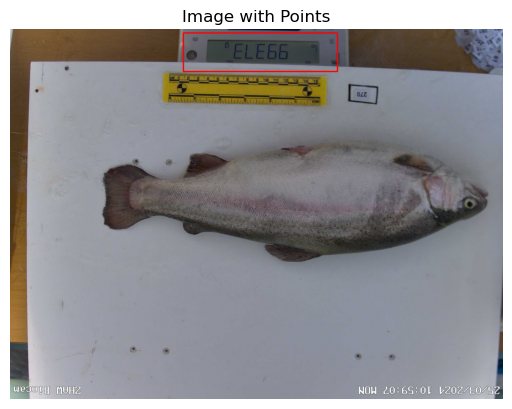

'99373'

In [23]:
get_labels(900, 20, 800, 200, df.iloc[30]['id'], 
           can_be_flipped = True,
           show =True,
           # equalize = True,
           # gray = True, 
           # binary= True
          )

In [91]:
labels = []
for path in df['id']:
    labels.append(get_labels(900, 20, 800, 200, path, 
           can_be_flipped = True,
           # equalize = True,
           # gray = True,
                ))

Can't find the file: FishDiseaseZHAW/OverUnderWeight/.ipynb_checkpoints
Skipping this file


In [93]:
labels_df = pd.DataFrame(labels)

In [98]:
df.to_csv(path_or_buf = 'over_under_weight.csv', columns=df.columns)